##Load Data

In [1]:
!gdown 1OgYbPfXFAv3TbwP1Qcwt_CC9cVWSJaco

Downloading...
From: https://drive.google.com/uc?id=1OgYbPfXFAv3TbwP1Qcwt_CC9cVWSJaco
To: /content/indosum.tar.gz
100% 96.0M/96.0M [00:01<00:00, 51.9MB/s]


In [2]:
import tarfile

with tarfile.open('indosum.tar.gz') as tar:
    tar.extractall()
    tar.close()

In [3]:
import os
import json

BASE_PATH = './indosum'
indosum = {
    'train': [],
    'dev': [],
    'test': []
}

for json_file in os.listdir('indosum'):
    if json_file.endswith('.jsonl'):
        split, fold, ext = json_file.split('.')
        file_path = os.path.join(BASE_PATH, json_file)
        
        with open(file_path, 'r') as json_file:
            json_list = list(json_file)
            for json_str in json_list:
                result = json.loads(json_str)
                indosum[split].append(result)
            

with open('indosum.json', 'w', encoding='utf-8') as f:
    json.dump(indosum, f, ensure_ascii=False, indent=2)
    

In [4]:
import re

def add_start_end_sequence(summary):
    summary = 'sostok ' + summary + ' eostok'
    return summary

def convert_to_words(news_file, to_article=False):
    content_words = []
    for paragraph in news_file['paragraphs']:
        for sentence in paragraph:
            for word in sentence:
                if re.match('[A-Za-z0-9]+', word):
                    word = str(word).lower()
                    content_words.append(word) 

    summary_words = []
    for sentence in news_file['summary']:
        for word in sentence:
            if re.match('[A-Za-z0-9]+', word):
                word = str(word).lower()
                summary_words.append(word)

    content_words = ' '.join(content_words)
    summary_words = ' '.join(summary_words)

    summary_words = add_start_end_sequence(summary_words)
    
    news_file['paragraphs'] = content_words
    news_file['summary'] = summary_words

In [5]:
for split in indosum.keys():
    for news in indosum[split]:
        convert_to_words(news)

In [6]:
print(indosum['dev'][5]['paragraphs'])
print(indosum['dev'][5]['summary'])

jakarta cnn indonesia channing tatum seharusnya mengawali debutnya sebagai sutradara lewat film remaja forgive me leonard peacock namun skandal seks harvey weinstein menghentikan langkahnya tatum sepertinya tak mau dikait kaitkan dengan dugaan pelecehan seksual yang tengah menimpa weinstein ia pun melanjutkan untuk tidak melanjutkan proyek film yang akan disutradarainya pasalnya film itu dibiayai oleh perusahaan the weinstein company padahal aktor berusia 37 tahun itu telah bersiap menjalani proyek bersama reid carolin namun ia mengumumkan pengunduran dirinya melalui instagram dengan 15 juta pengikut perempuan tangguh yang berani untuk berdiri dan mengatakan kebenaran tentang harvey weinstein adalah pahlawan sejati bagi kami kata sang aktor mengawali pengumumannya mereka mengangkat beban batu bata berat untuk membangun dunia yang layak kita tinggali lebih lanjut tatum mengatakan bahwa proyek tunggal kerjasamanya dengan twc itu mengadaptasi buku forgive me leonard peacock karya matthew 

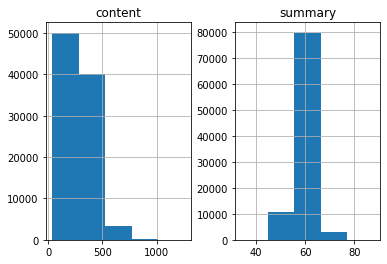

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

def visualize_words_distribution(dataset_dict):
    content_count = []
    summary_count = []

    for split in dataset_dict.keys():
        for news in dataset_dict[split]:
            content_word_count = len(news['paragraphs'].split(' '))
            summary_word_count = len(news['summary'].split(' '))
            content_count.append(content_word_count)
            summary_count.append(summary_word_count)

    average_length = pd.DataFrame() 

    average_length['content'] = content_count
    average_length['summary'] = summary_count

    average_length.hist(bins = 5)
    plt.show()
    return average_length

average_length = visualize_words_distribution(indosum)          

In [8]:
def count_words_length_percentage(max_len, length_list):
    cnt = 0
    for length in length_list:
        if length <= max_len:
            cnt = cnt + 1
    return cnt / len(length_list)

max_len_content = 600
max_len_summary = 65

print(count_words_length_percentage(max_len_content, average_length['content']))
print(count_words_length_percentage(max_len_summary, average_length['summary']))

0.9818791946308725
0.944710770214126


In [9]:
indosum_new = {
    'train': [],
    'dev': [],
    'test': []
}

for split in indosum_new.keys():
    for news in indosum[split]:
        content_len = len(news['paragraphs'].split(' '))
        summary_len = len(news['summary'].split(' '))
        if (content_len <= max_len_content) and (summary_len <= max_len_summary):
            indosum_new[split].append(news)

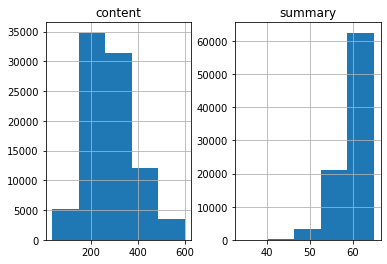

In [10]:
average_length_new = visualize_words_distribution(indosum_new)

##Split Train, Dev, Test

In [11]:
X = {
    'train': [],
     'dev': [],
     'test': []
}
for split in indosum_new.keys():
    for news in indosum_new[split]:
        X[split].append(news['paragraphs'])

y = {
    'train': [],
     'dev': [],
     'test': []
}
for split in indosum_new.keys():
    for news in indosum_new[split]:
        y[split].append(news['summary'])

In [12]:
X_train, X_dev, X_test = X['train'], X['dev'], X['test']
y_train, y_dev, y_test = y['train'], y['dev'], y['test']

##(Experimental) Word Embedding

In [13]:
#!pip install fasttext

In [14]:
#import fasttext
#import fasttext.util
 
#fasttext.util.download_model('id', if_exists='ignore')

In [15]:
#ft = fasttext.load_model("cc.id.300.bin")
#ft.get_dimension()

In [16]:
#fasttext.util.reduce_model(ft, 100)
#ft.get_dimension()

#Tokenization

In [17]:
# Tokenize the text to get the vocab count 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Prepare a tokenizer on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(np.array(X_train))

In [18]:
def count_rare_words(threshold, tokenizer):
    cnt = 0
    tot_cnt = 0

    for key, value in tokenizer.word_counts.items():
        tot_cnt = tot_cnt + 1
        if value < threshold:
            cnt = cnt + 1
    
    print('Threshold: {}'.format(threshold))
    print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

    return cnt, tot_cnt

cnt, tot_cnt = count_rare_words(10, x_tokenizer)

Threshold: 10
% of rare words in vocabulary:  54.2548022094626


In [19]:
# Prepare a tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
x_tokenizer.fit_on_texts(np.array(X_train))

# Convert text sequences to integer sequences 
x_train_seq = x_tokenizer.texts_to_sequences(X_train) 
x_dev_seq = x_tokenizer.texts_to_sequences(X_dev)
x_test_seq = x_tokenizer.texts_to_sequences(X_test)

# Pad zero upto maximum length
x_train = pad_sequences(x_train_seq,  maxlen=max_len_content, padding='post')
x_dev = pad_sequences(x_dev_seq, maxlen=max_len_content, padding='post')
x_test = pad_sequences(x_test_seq,  maxlen=max_len_content, padding='post')

# Size of vocabulary (+1 for padding token)
x_vocab = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_vocab))

Size of vocabulary in X = 46130


In [20]:
# Prepare a tokenizer on test data
y_tokenizer = Tokenizer() 
y_tokenizer.fit_on_texts(np.array(y_train))

cnt_test, tot_cnt_test = count_rare_words(10, y_tokenizer)

Threshold: 10
% of rare words in vocabulary:  56.45501551189245


In [21]:
# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words = tot_cnt_test - cnt_test) 
y_tokenizer.fit_on_texts(np.array(y_train))

# Convert text sequences to integer sequences 
y_train_seq = y_tokenizer.texts_to_sequences(y_train) 
y_dev_seq = y_tokenizer.texts_to_sequences(y_dev)
y_test_seq = y_tokenizer.texts_to_sequences(y_test)

# Pad zero upto maximum length
y_train = pad_sequences(y_train_seq,  maxlen=max_len_summary, padding='post')
y_dev = pad_sequences(y_dev_seq, maxlen=max_len_summary, padding='post')
y_test = pad_sequences(y_test_seq,  maxlen=max_len_summary, padding='post')

# Size of vocabulary (+1 for padding token)
y_vocab = y_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(y_vocab))

Size of vocabulary in X = 21055


In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, \
    Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
latent_dim = 300
embedding_dim = 300

# Encoder
encoder_inputs = Input(shape=(max_len_content, ))

# Embedding layer
enc_emb = Embedding(x_vocab, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_vocab, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_vocab, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 600, 300)     13839000    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 600, 300),   721200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [24]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [25]:
 nhistory = model.fit(
    [x_train, y_train[:, :-1]],
    y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:, 1:],
    epochs=50,
    callbacks=[es],
    batch_size=128,
    validation_data=([x_dev, y_dev[:, :-1]],
                     y_dev.reshape(y_dev.shape[0], y_dev.shape[1], 1)[:
                     , 1:]),
    )

Epoch 1/50
518/518 [==============================] - 397s 744ms/step - loss: 6.7173 - val_loss: 6.0545
Epoch 2/50
518/518 [==============================] - 385s 744ms/step - loss: 5.6848 - val_loss: 5.3503
Epoch 3/50
518/518 [==============================] - 385s 744ms/step - loss: 5.1372 - val_loss: 4.9529
Epoch 4/50
518/518 [==============================] - 385s 744ms/step - loss: 4.7866 - val_loss: 4.6828
Epoch 5/50
518/518 [==============================] - 385s 744ms/step - loss: 4.5297 - val_loss: 4.4879
Epoch 6/50
518/518 [==============================] - 385s 744ms/step - loss: 4.3221 - val_loss: 4.3175
Epoch 7/50
518/518 [==============================] - 385s 744ms/step - loss: 4.1510 - val_loss: 4.1795
Epoch 8/50
518/518 [==============================] - 385s 744ms/step - loss: 4.0047 - val_loss: 4.0577
Epoch 9/50
518/518 [==============================] - 385s 744ms/step - loss: 3.8782 - val_loss: 3.9513
Epoch 10/50
518/518 [==============================] - 385s 744m

##Save Model

In [26]:
model.save('baseline_1a')  

INFO:tensorflow:Assets written to: baseline_1a/assets


INFO:tensorflow:Assets written to: baseline_1a/assets


In [27]:
!zip -r /content/baseline_1a.zip /content/baseline_1a/

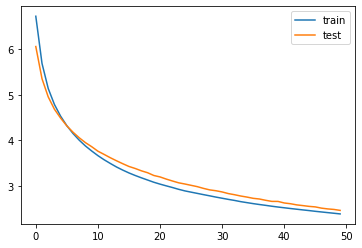

In [28]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [29]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [30]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_len_content, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [31]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_len_summary - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [32]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

In [33]:
for i, news in enumerate(x_test):
    if i == 10:
        break
    print ('Review:', seq2text(news))
    print ('Original summary:', seq2summary(y_test[i]))
    print ('Predicted summary:', decode_sequence(news.reshape(1,
           max_len_content)))
    print ('\n')

Review: cirebon jawa barat antara news sebanyak 30 karyawan mengalami keracunan setelah terjadi kebocoran pipa gas amonia di pt suri tani pemuka di kabupaten cirebon jawa barat sabtu kebocoran saluran gas amonia yang terjadi di pt suri tani sekitar pukul 13 00 wib itu menyebabkan 30 pegawai mengalami keracunan kata kabid humas polda jawa barat komisaris besar polisi yusri yunus saat dihubungi dari cirebon sabtu yunus mengatakan dari keterangan saksi bahwa pada saat dirinya bekerja mendapat informasi di ruangan produksi terdapat kebocoran saluran gas amonia kemudian saksi mendatangi lokasi serta memerintahkan kepada seluruh karyawan untuk keluar ruangan namun setelah para karyawan keluar ruangan terdapat beberapa karyawan jatuh pingsan yang kemudian langsung dibawa ke rumah sakit oleh pihak perusahaan dibantu dengan pihak kepolisian tuturnya yusri menjelaskan kebocoran gas amonia tersebut berasal dari pipa gudang pendingin nomor 4 yang berada di ruang produksi untuk saat ini pihak perus